# PyTorch practice, hints and Dataloaders

Credits:
* First part is based on YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will remind you how to use pytorch low and high-level core. You can install it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms

### Task 1: Tensormancy

__1.1 The [_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

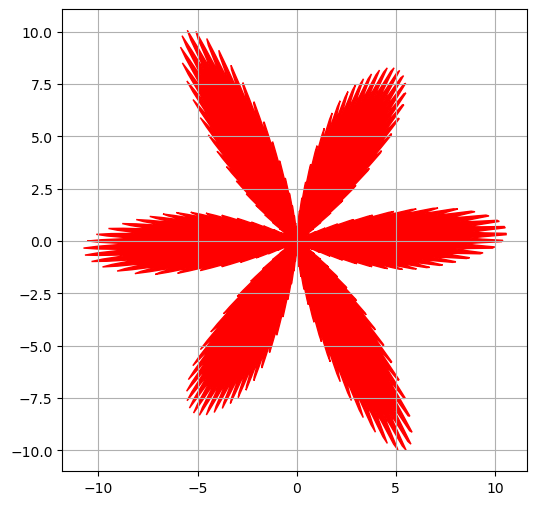

In [3]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(6 * theta)) * (1 + 0.01 * torch.cos(24 * theta)) * (0.5 + 0.05 * torch.cos(200 * theta)) * (10 + torch.sin(10 * theta)) ### YOUR CODE HERE

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * torch.cos(theta) ### YOUR CODE HERE
y = rho * torch.sin(theta) ### YOUR CODE HERE


plt.figure(figsize=(6, 6))
plt.fill(x.numpy(), y.numpy(), color='red')
plt.grid()

### Task 2: Using the Dataloader

In [4]:
from torch import nn
from torch.nn import functional as F

In [5]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/21f_basic/week0_08_dropout_batchnorm/notmnist.py -nc

File ‘notmnist.py’ already there; not retrieving.



In [6]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8259k  100 8259k    0     0   211k      0  0:00:39  0:00:39 --:--:--  175k


Extracting ...
Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [7]:
class DatasetMNIST(Dataset):
    def __init__(self, path='./notMNIST_small', letters='ABCDEFGHIJ', transform=None):
        self.data, self.labels, _ ,_  = load_notmnist(path=path, letters=letters, test_size=0)
        self.transform = transform

    def __len__(self):
        return len(self.data) 

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index].transpose(1, 2, 0)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [8]:
full_dataset = DatasetMNIST('./notMNIST_small', 'AB', transform=None)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [10]:
# we can access and get data with index by __getitem__(index)
img, lab = full_dataset.__getitem__(0) # not recommended
img, lab = full_dataset[0] # recommended

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [11]:
a = torchvision.transforms.ToTensor()
 
a(img).shape

torch.Size([1, 28, 28])

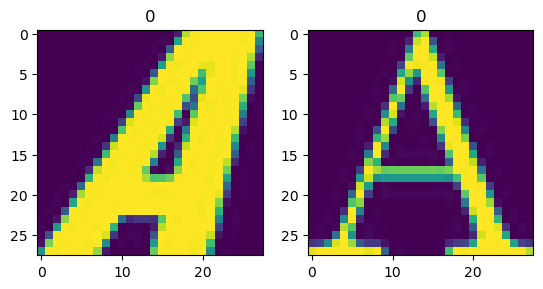

In [12]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28,28]))
    plt.title(str(full_dataset[inds[i]][1]))

#### To the DataLoader

In [13]:
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True)

We can use dataloader as iterator by using iter() function.

In [14]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


And now with transformations:

In [17]:
train_dataset_with_transform = DatasetMNIST(
    transform=torchvision.transforms.ToTensor()
)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [18]:
img, lab = train_dataset_with_transform[0]

print('image shape at the first row : {}'.format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [20]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


### Composing several transformations

If you want to take data augmentation, you have to make List using `torchvision.transforms.Compose`

```
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```


this function can convert some image by order within `__call__` method.

In [21]:
class Flatten():
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [22]:
a = Flatten()

In [23]:
a(img).shape

torch.Size([784])

In [24]:
new_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Flatten()
])

# Putting all together

In [25]:
import time

from IPython.display import clear_output

In [26]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [28]:
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [29]:
dataset = DatasetMNIST(
    './notMNIST_small',
    transform=new_transform
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f'\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}')

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


 dataset size: 3744, labels: [0 1 2 3 4 5 6 7 8 9]


In [30]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset,  [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f'  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

  training size: 2996
validation size: 748


In [32]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [34]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


In [35]:
loss_func = nn.CrossEntropyLoss()

In [43]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 10),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [44]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # compute predictions
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch) 
                
                ep_val_loss.append(loss.item())
                y_pred =  y_pred.max(dim=1)[1]
                ep_val_accuracy.append((y_pred == y_batch).detach().cpu().numpy().mean())

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [45]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.256s
	  training loss: 0.810276
	validation loss: 0.549439
	validation accuracy: 0.867
Epoch 2 of 30 took 0.203s
	  training loss: 0.490282
	validation loss: 0.504452
	validation accuracy: 0.885
Epoch 3 of 30 took 0.234s
	  training loss: 0.432248
	validation loss: 0.493519
	validation accuracy: 0.878
Epoch 4 of 30 took 0.231s
	  training loss: 0.395901
	validation loss: 0.486834
	validation accuracy: 0.880
Epoch 5 of 30 took 0.200s
	  training loss: 0.370414
	validation loss: 0.490720
	validation accuracy: 0.872
Epoch 6 of 30 took 0.219s
	  training loss: 0.345741
	validation loss: 0.490579
	validation accuracy: 0.880
Epoch 7 of 30 took 0.211s
	  training loss: 0.325936
	validation loss: 0.491971
	validation accuracy: 0.879
Epoch 8 of 30 took 0.223s
	  training loss: 0.306184
	validation loss: 0.489638
	validation accuracy: 0.878
Epoch 9 of 30 took 0.213s
	  training loss: 0.295252
	validation loss: 0.502618
	validation accuracy: 0.882
Epoch 10 of 30 took 0.219s
	

In [46]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

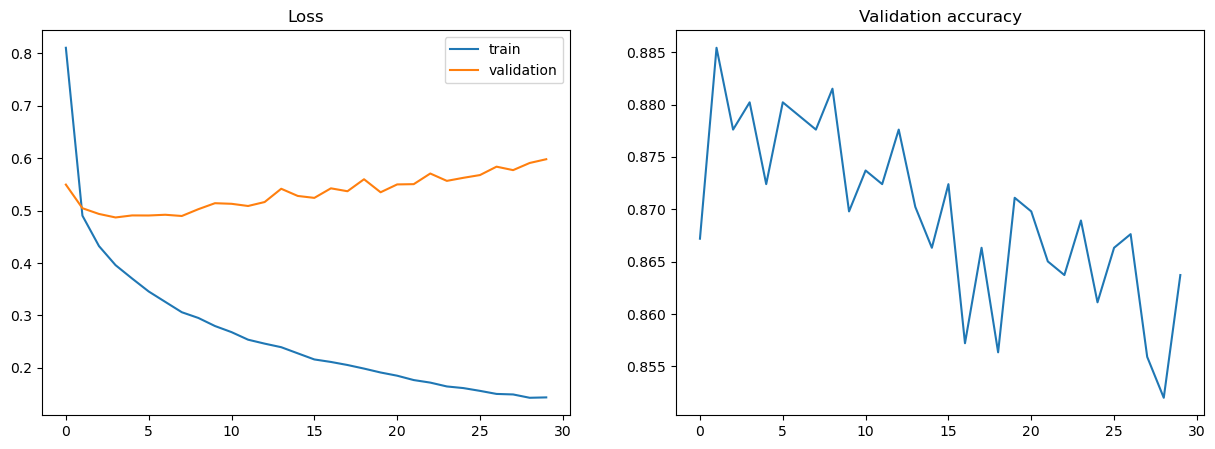

In [47]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Real network

In [48]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(), 
    nn.Linear(200, 10),
 )
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [49]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 1.037s
	  training loss: 0.681670
	validation loss: 0.401704
	validation accuracy: 0.892
Epoch 2 of 30 took 0.743s
	  training loss: 0.355039
	validation loss: 0.396800
	validation accuracy: 0.892
Epoch 3 of 30 took 0.765s
	  training loss: 0.252204
	validation loss: 0.438646
	validation accuracy: 0.879
Epoch 4 of 30 took 0.964s
	  training loss: 0.174287
	validation loss: 0.468489
	validation accuracy: 0.890
Epoch 5 of 30 took 0.723s
	  training loss: 0.134599
	validation loss: 0.444738
	validation accuracy: 0.891
Epoch 6 of 30 took 0.762s
	  training loss: 0.103045
	validation loss: 0.509980
	validation accuracy: 0.882
Epoch 7 of 30 took 0.724s
	  training loss: 0.089676
	validation loss: 0.537864
	validation accuracy: 0.880
Epoch 8 of 30 took 0.714s
	  training loss: 0.058675
	validation loss: 0.502438
	validation accuracy: 0.898
Epoch 9 of 30 took 0.680s
	  training loss: 0.064113
	validation loss: 0.504592
	validation accuracy: 0.902
Epoch 10 of 30 took 0.648s
	

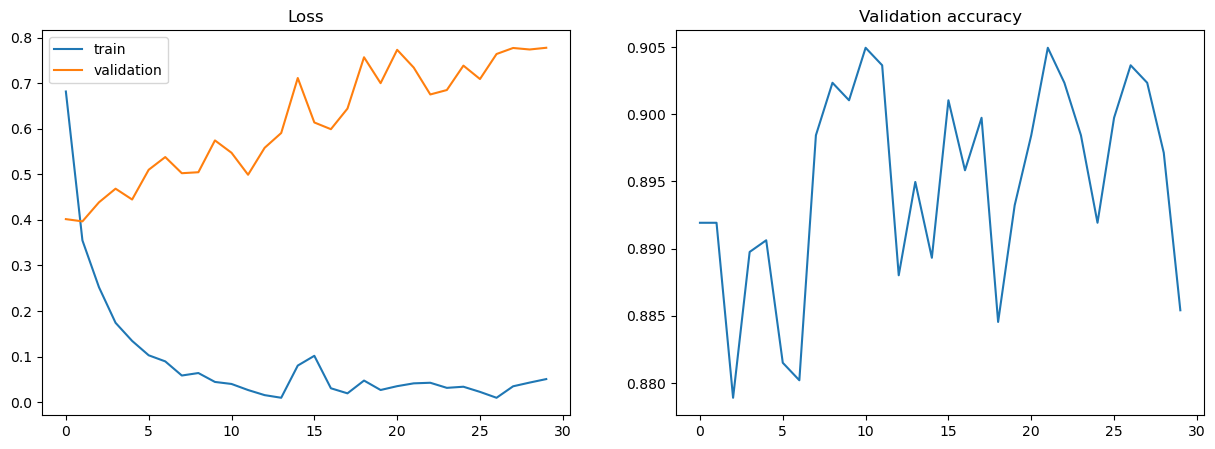

In [50]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Your turn
Try to add some additional transformations (e.g. random crop, rotation etc.) and train your model!

In [54]:
model = nn.Sequential(
    nn.Linear(784, 64),
    nn.GELU(),
    nn.Dropout(0.5),
    
    nn.Linear(64, 32),
    nn.GELU(), 
    nn.BatchNorm1d(32),
    
    nn.Linear(32, 16),
    nn.GELU(),
    nn.BatchNorm1d(16),
    
    nn.Linear(16, 10),
 )
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [55]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.573s
	  training loss: 1.574079
	validation loss: 1.053431
	validation accuracy: 0.791
Epoch 2 of 30 took 0.459s
	  training loss: 1.017552
	validation loss: 0.647068
	validation accuracy: 0.872
Epoch 3 of 30 took 0.470s
	  training loss: 0.742324
	validation loss: 0.496487
	validation accuracy: 0.887
Epoch 4 of 30 took 0.488s
	  training loss: 0.641178
	validation loss: 0.446614
	validation accuracy: 0.882
Epoch 5 of 30 took 0.499s
	  training loss: 0.559644
	validation loss: 0.408337
	validation accuracy: 0.892
Epoch 6 of 30 took 0.518s
	  training loss: 0.511782
	validation loss: 0.399798
	validation accuracy: 0.889
Epoch 7 of 30 took 0.649s
	  training loss: 0.488279
	validation loss: 0.363658
	validation accuracy: 0.896
Epoch 8 of 30 took 0.527s
	  training loss: 0.447510
	validation loss: 0.376893
	validation accuracy: 0.898
Epoch 9 of 30 took 0.556s
	  training loss: 0.418576
	validation loss: 0.359510
	validation accuracy: 0.898
Epoch 10 of 30 took 0.550s
	

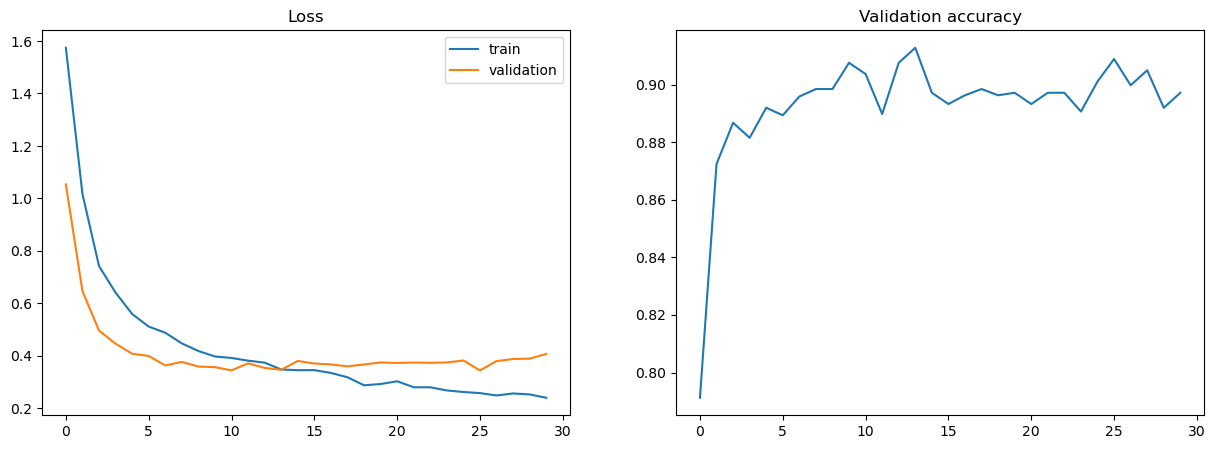

In [56]:
plot_train_process(train_loss, val_loss, val_accuracy)

### 3. Save the model (model checkpointing)

Now we have trained a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [57]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [58]:
model = nn.Sequential(
    nn.Linear(784, 64),
    nn.GELU(),
    nn.Dropout(0.5),
    
    nn.Linear(64, 32),
    nn.GELU(), 
    nn.BatchNorm1d(32),
    
    nn.Linear(32, 16),
    nn.GELU(),
    nn.BatchNorm1d(16),
    
    nn.Linear(16, 10),
 )
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

#### Define a training loop with model checkpointing

In [59]:
def train_model_with_save(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, save_interval=5):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # compute predictions
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch) 
                
                ep_val_loss.append(loss.item())
                y_pred =  y_pred.max(dim=1)[1]
                ep_val_accuracy.append((y_pred == y_batch).detach().cpu().numpy().mean())

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")
        
        if epoch % save_interval == 0 and epoch > 0:
            save_checkpoint(f'mnist-{epoch}.pth', model, opt)
            
    # save the final model
    save_checkpoint(f'mnist-{n_epochs}.pth', model, opt)
 
    return train_loss, val_loss, val_accuracy

In [60]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model_with_save(model, 
                                                 train_loader, 
                                                 val_loader, 
                                                 loss_func, 
                                                 opt, 
                                                 n_epochs, 
                                                 save_interval=5)

Epoch 1 of 30 took 0.523s
	  training loss: 1.574443
	validation loss: 1.025177
	validation accuracy: 0.859
Epoch 2 of 30 took 0.510s
	  training loss: 1.014840
	validation loss: 0.678974
	validation accuracy: 0.869
Epoch 3 of 30 took 0.531s
	  training loss: 0.774406
	validation loss: 0.507580
	validation accuracy: 0.887
Epoch 4 of 30 took 0.509s
	  training loss: 0.631898
	validation loss: 0.440198
	validation accuracy: 0.891
Epoch 5 of 30 took 0.614s
	  training loss: 0.565886
	validation loss: 0.409678
	validation accuracy: 0.888
Epoch 6 of 30 took 0.546s
	  training loss: 0.501414
	validation loss: 0.418737
	validation accuracy: 0.895
model saved to mnist-5.pth
Epoch 7 of 30 took 0.509s
	  training loss: 0.470339
	validation loss: 0.383104
	validation accuracy: 0.892
Epoch 8 of 30 took 0.625s
	  training loss: 0.427844
	validation loss: 0.361692
	validation accuracy: 0.897
Epoch 9 of 30 took 0.568s
	  training loss: 0.425238
	validation loss: 0.362990
	validation accuracy: 0.892
E

In [61]:
!ls mnist*.pth

mnist-10.pth  mnist-20.pth  mnist-30.pth
mnist-15.pth  mnist-25.pth  mnist-5.pth


In [62]:
# load model
model = nn.Sequential(
    nn.Linear(784, 64),
    nn.GELU(),
    nn.Dropout(0.5),
    
    nn.Linear(64, 32),
    nn.GELU(), 
    nn.BatchNorm1d(32),
    
    nn.Linear(32, 16),
    nn.GELU(),
    nn.BatchNorm1d(16),
    
    nn.Linear(16, 10),
 )
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

load_checkpoint('mnist-30.pth', model, opt)

model loaded from mnist-30.pth


### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)